In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.max_columns = 999
sns.set_style('whitegrid')

# https://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import RobustScaler, OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
df = pd.read_csv('PHL_Building_Dataset_ML_Classification.csv')
df = df.drop(columns=['Unnamed: 0', 'basements_bin'])
df

,basements,building_code_description,central_air,depth,exterior_condition,fireplaces,frontage,garage_type,interior_condition,location,market_value,number_of_bathrooms,number_of_bedrooms,number_of_rooms,number_stories,parcel_shape,street_designation,topography,total_area,total_livable_area,type_heater,view_type,year_built,zoning,building_description,section,segment
0,0,ROW B/GAR 2 STY MASONRY,Y,90.00,4.0,0.0,29.17,A,4.0,220 WHARTON ST,257500.0,2.0,3.0,6.0,2.0,E,ST,6,2625.30,1266.0,H,I,1960.0,1,MASONRY,South,2
1,0,ROW B/GAR 2 STY MASONRY,Y,90.00,4.0,0.0,18.03,A,4.0,222 WHARTON ST,249400.0,2.0,3.0,6.0,2.0,E,ST,6,1622.70,1266.0,A,I,1960.0,1,MASONRY,South,2
2,0,ROW B/GAR 2 STY MASONRY,Y,90.00,4.0,0.0,18.05,A,4.0,224 WHARTON ST,249500.0,2.0,3.0,6.0,2.0,E,ST,6,1624.50,1266.0,A,I,1960.0,1,MASONRY,South,2
3,0,ROW B/GAR 2 STY MASONRY,Y,90.00,4.0,0.0,18.08,A,4.0,226 WHARTON ST,249500.0,2.0,3.0,6.0,2.0,E,ST,6,1627.20,1266.0,H,I,1960.0,1,MASONRY,South,2
4,0,ROW B/GAR 2 STY MASONRY,Y,90.00,4.0,0.0,18.71,A,4.0,228 WHARTON ST,253800.0,2.0,3.0,6.0,2.0,E,ST,6,1683.90,1310.0,H,I,1960.0,1,MASONRY,South,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44479,D,ROW 3 STY MASONRY,N,100.00,4.0,0.0,21.87,0,4.0,3434 W CLEARFIELD ST,117500.0,0.0,3.0,6.0,3.0,A,ST,6,1651.00,2907.0,H,I,1929.0,1,MASONRY,North,1
44480,D,ROW 2 STY MASONRY,Y,102.19,3.0,0.0,18.24,0,3.0,1121 CARPENTER ST,70800.0,2.0,3.0,9.0,3.0,A,ST,6,1811.00,2026.0,A,I,2005.0,1,MASONRY,South,1
44481,D,ROW 3 STY MASONRY,Y,103.26,3.0,0.0,16.00,0,3.0,1208 MONTROSE ST,23600.0,1.0,3.0,6.0,3.0,A,ST,6,1604.00,2082.0,A,I,2005.0,1,MASONRY,South,1
44482,D,ROW 3 STY MASONRY,Y,90.00,3.0,0.0,16.00,0,3.0,1212 MONTROSE ST,23600.0,1.0,3.0,6.0,3.0,E,ST,6,1440.00,1387.0,A,I,2005.0,1,MASONRY,South,1


In [5]:
# Rename Segment
df['segment'] = df['segment'].replace({1:'Bottom', 2:'Lower Middle', 3:'Middle', 4:'Upper Middle', 5:'Top'})

# Splitting Data

In [6]:
X = df.drop(columns=['building_code_description', 'segment'])
y = df['segment']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

# Evaluation Matrix

In [8]:
# Evaluation Matrix Classification
def Eva_Matrix1(Model, X_train, y_train, X_test, y_test, Name):
    y_pred_train = Model.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    rec_train = recall_score(y_train, y_pred_train)
    prec_train = precision_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    y_pred_test = Model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    rec_test = recall_score(y_test, y_pred_test)
    prec_test = precision_score(y_test, y_pred_test)
    f1_test = f1_score(y_train, y_pred_train)
    data = {
        f"Training {Name}" : [acc_train, rec_train, prec_train, f1_train],
        f"Test {Name}" : [acc_test, rec_test, prec_test, f1_test]
    }
    df = pd.DataFrame(data=data, index=['Accuracy', 'Recall', 'Precision', 'F1'])
    return df

# Pipeline

In [9]:
# Based on EDA there are several columns that we choose for Machine Learning Modelling
num_columns = ['fireplaces', 'market_value', 'number_of_rooms', 'total_area', 
               'total_livable_area']

cat_columns = ['basements', 'central_air', 'exterior_condition', 'garage_type',
               'interior_condition', 'parcel_shape', 'topography',
               'type_heater', 'view_type', 'building_description']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    #('scaler', RobustScaler()),
    #('poly', PolynomialFeatures(degree=3, include_bias=False)),
    #('power', PowerTransformer(method='yeo-johnson'))
])

categoric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categoric', categoric_pipeline, cat_columns)
])

pipeSVM = Pipeline([
    ("prep", preprocessor),
    ("algo", SVC(max_iter=400, probability=True))
])

pipeLR = Pipeline([
    ("prep", preprocessor),
    ("algo", LogisticRegression())
])

pipeKNN = Pipeline([
    ("prep", preprocessor),
    ("algo", KNeighborsClassifier())
])
               
pipeDT = Pipeline([
    ("prep", preprocessor),
    ("algo", DecisionTreeClassifier())
])
            
pipeRF = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier())
])

# Base Model (KNN)

In [10]:
pipeKNN.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [11]:
y_KNN_train = pipeKNN.predict(X_train)

In [12]:
y_KNN_test = pipeKNN.predict(X_test)

In [13]:
accuracy_train_KNN_base = accuracy_score(y_train, y_KNN_train)
accuracy_train_KNN_base

0.9995784977660381

In [14]:
accuracy_test_KNN_base = accuracy_score(y_test, y_KNN_test)
accuracy_test_KNN_base

0.9993256153759694

In [15]:
f1score_train_KNN_base = f1_score(y_train, y_KNN_train, average='weighted')
f1score_train_KNN_base

0.9995783772072708

In [16]:
f1score_test_KNN_base = f1_score(y_test, y_KNN_test, average='weighted')
f1score_test_KNN_base

0.999324419559254

In [17]:
print(classification_report(y_test, y_KNN_test))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      4788
Lower Middle       1.00      1.00      1.00      3089
      Middle       1.00      1.00      1.00       826
         Top       1.00      1.00      1.00        42
Upper Middle       1.00      0.98      0.99       152

    accuracy                           1.00      8897
   macro avg       1.00      1.00      1.00      8897
weighted avg       1.00      1.00      1.00      8897



# Base Model Logistic Regression

In [18]:
pipeLR.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [19]:
y_LR_train = pipeLR.predict(X_train)

In [20]:
y_LR_test = pipeLR.predict(X_test)

In [21]:
accuracy_train_LR_base = accuracy_score(y_train, y_LR_train)
accuracy_train_LR_base

0.7611487340882906

In [22]:
accuracy_test_LR_base = accuracy_score(y_test, y_LR_test)
accuracy_test_LR_base

0.7591322917837473

In [23]:
f1score_train_LR_base = f1_score(y_train, y_LR_train, average='weighted')
f1score_train_LR_base

0.7330742237283698

In [24]:
f1score_test_LR_base = f1_score(y_test, y_LR_test, average='weighted')
f1score_test_LR_base

0.7306879498495213

In [25]:
print(classification_report(y_test, y_LR_test))

              precision    recall  f1-score   support

      Bottom       0.86      0.90      0.88      4788
Lower Middle       0.65      0.77      0.71      3089
      Middle       0.36      0.08      0.13       826
         Top       0.09      0.07      0.08        42
Upper Middle       0.32      0.05      0.08       152

    accuracy                           0.76      8897
   macro avg       0.46      0.37      0.37      8897
weighted avg       0.73      0.76      0.73      8897



# Base Model SVM

In [26]:
pipeSVM.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [27]:
y_SVM_train = pipeSVM.predict(X_train)

In [28]:
y_SVM_test = pipeSVM.predict(X_test)

In [29]:
accuracy_train_SVM_base = accuracy_score(y_train, y_SVM_train)
accuracy_train_SVM_base

0.9610812937308568

In [30]:
accuracy_test_SVM_base = accuracy_score(y_test, y_SVM_test)
accuracy_test_SVM_base

0.9598741148701809

In [31]:
f1score_train_SVM_base = f1_score(y_train, y_SVM_train, average='weighted')
f1score_train_SVM_base

0.9613909769487187

In [32]:
f1score_test_SVM_base = f1_score(y_test, y_SVM_test, average='weighted')
f1score_test_SVM_base

0.9601902867356089

In [33]:
print(classification_report(y_test, y_SVM_test))

              precision    recall  f1-score   support

      Bottom       1.00      0.93      0.96      4788
Lower Middle       0.90      1.00      0.95      3089
      Middle       0.99      1.00      1.00       826
         Top       1.00      1.00      1.00        42
Upper Middle       1.00      0.97      0.98       152

    accuracy                           0.96      8897
   macro avg       0.98      0.98      0.98      8897
weighted avg       0.96      0.96      0.96      8897



# Base Model (DecisionTreeClassifier)

In [34]:
pipeDT.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [35]:
y_DT_train = pipeDT.predict(X_train)

In [36]:
y_DT_test = pipeDT.predict(X_test)

In [37]:
accuracy_train_DT_base = accuracy_score(y_train, y_DT_train)
accuracy_train_DT_base

1.0

In [38]:
accuracy_test_DT_base = accuracy_score(y_test, y_DT_test)
accuracy_test_DT_base

0.9998876025626616

In [39]:
f1score_train_DT_base = f1_score(y_train, y_DT_train, average='weighted')
f1score_train_DT_base

1.0

In [40]:
f1score_test_DT_base = f1_score(y_test, y_DT_test, average='weighted')
f1score_test_DT_base

0.9998875776185774

In [41]:
print(classification_report(y_test, y_DT_test))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      4788
Lower Middle       1.00      1.00      1.00      3089
      Middle       1.00      1.00      1.00       826
         Top       1.00      1.00      1.00        42
Upper Middle       1.00      1.00      1.00       152

    accuracy                           1.00      8897
   macro avg       1.00      1.00      1.00      8897
weighted avg       1.00      1.00      1.00      8897



# Base Model (Random Forest Classifier)

In [42]:
pipeRF.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [43]:
y_RF_train = pipeRF.predict(X_train)

In [44]:
y_RF_test = pipeRF.predict(X_test)

In [45]:
accuracy_train_RF_base = accuracy_score(y_train, y_RF_train)
accuracy_train_RF_base

1.0

In [46]:
accuracy_test_RF_base = accuracy_score(y_test, y_RF_test)
accuracy_test_RF_base

0.9966280768798471

In [47]:
f1score_train_RF_base = f1_score(y_train, y_RF_train, average='weighted')
f1score_train_RF_base

1.0

In [48]:
f1score_test_RF_base = f1_score(y_test, y_RF_test, average='weighted')
f1score_test_RF_base

0.9965470607603603

In [49]:
print(classification_report(y_test, y_RF_test))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      4788
Lower Middle       1.00      1.00      1.00      3089
      Middle       0.98      1.00      0.99       826
         Top       1.00      0.83      0.91        42
Upper Middle       0.94      0.88      0.91       152

    accuracy                           1.00      8897
   macro avg       0.98      0.94      0.96      8897
weighted avg       1.00      1.00      1.00      8897



# =================================================

# Hyper Parameter Tuning

## Logistic Regression

In [50]:
skf = StratifiedKFold(n_splits=3, random_state=42)

param_LR = {
    "algo__C" : np.logspace(-3, 3, 7),
    "algo__penalty" : ['l1', 'l2', 'elasticnet'],
    "algo__fit_intercept" : [True,False]
}

GS_LR = GridSearchCV(pipeLR, param_LR, cv = skf, n_jobs = -1, verbose = 1, scoring='balanced_accuracy')
GS_LR.fit(X_train, y_train)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:  2.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['fireplaces',
                                                                          'market_value',
                                                                          'number_of_rooms',
                                                                          'total_area',
                                                                          'total_livable_area']),
                                                                        ('categoric',
                                     

In [51]:
GS_LR.best_params_

{'algo__C': 0.001, 'algo__fit_intercept': True, 'algo__penalty': 'l2'}

In [52]:
LR_Tuned = GS_LR.best_estimator_

In [53]:
y_LR_Tuned_train = LR_Tuned.predict(X_train)

In [54]:
y_LR_Tuned_test = LR_Tuned.predict(X_test)

In [55]:
accuracy_train_LR_HyperTune = accuracy_score(y_train, y_LR_Tuned_train)
accuracy_train_LR_HyperTune

0.7603338297692978

In [56]:
accuracy_test_LR_HyperTune = accuracy_score(y_test, y_LR_Tuned_test)
accuracy_test_LR_HyperTune

0.7566595481623019

In [57]:
f1score_train_LR_HyperTune = f1_score(y_train, y_LR_Tuned_train, average='weighted')
f1score_train_LR_HyperTune

0.7309388493596513

In [58]:
f1score_test_LR_HyperTune = f1_score(y_test, y_LR_Tuned_test, average='weighted')
f1score_test_LR_HyperTune

0.7270923736458261

In [59]:
print(classification_report(y_test, y_LR_Tuned_test))

              precision    recall  f1-score   support

      Bottom       0.85      0.90      0.88      4788
Lower Middle       0.65      0.76      0.70      3089
      Middle       0.34      0.07      0.11       826
         Top       0.00      0.00      0.00        42
Upper Middle       0.22      0.04      0.07       152

    accuracy                           0.76      8897
   macro avg       0.41      0.35      0.35      8897
weighted avg       0.72      0.76      0.73      8897



# DecisionTreeClassifier

In [60]:
skf = StratifiedKFold(n_splits=3, random_state=42)

param_DT = {
   'algo__max_depth': [None, 5, 10, 15], 
   'algo__min_samples_leaf' : np.arange(1, 17, 5), 
   'algo__max_features' : [0.3, 0.5, 0.7, 0.8]
}

GS_DT = GridSearchCV(pipeDT, param_DT, cv = skf, n_jobs = -1, verbose = 1, scoring='balanced_accuracy')
GS_DT.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  1.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['fireplaces',
                                                                          'market_value',
                                                                          'number_of_rooms',
                                                                          'total_area',
                                                                          'total_livable_area']),
                                                                        ('categoric',
                                     

In [61]:
GS_DT.best_params_

{'algo__max_depth': None,
 'algo__max_features': 0.8,
 'algo__min_samples_leaf': 1}

In [62]:
DT_Tuned = GS_DT.best_estimator_

In [63]:
y_DT_Tuned_train = DT_Tuned.predict(X_train)

In [64]:
y_DT_Tuned_test = DT_Tuned.predict(X_test)

In [65]:
accuracy_train_DT_HyperTune = accuracy_score(y_train, y_DT_Tuned_train)
accuracy_train_DT_HyperTune

1.0

In [66]:
accuracy_test_DT_HyperTune = accuracy_score(y_test, y_DT_Tuned_test)
accuracy_test_DT_HyperTune

0.9998876025626616

In [67]:
f1score_train_DT_HyperTune = f1_score(y_train, y_DT_Tuned_train, average='weighted')
f1score_train_DT_HyperTune

1.0

In [68]:
f1score_test_DT_HyperTune = f1_score(y_test, y_DT_Tuned_test, average='weighted')
f1score_test_DT_HyperTune

0.9998875776185774

In [69]:
print(classification_report(y_test, y_DT_Tuned_test))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      4788
Lower Middle       1.00      1.00      1.00      3089
      Middle       1.00      1.00      1.00       826
         Top       1.00      1.00      1.00        42
Upper Middle       1.00      1.00      1.00       152

    accuracy                           1.00      8897
   macro avg       1.00      1.00      1.00      8897
weighted avg       1.00      1.00      1.00      8897



# RandomForestClassifier

In [70]:
skf = StratifiedKFold(n_splits=3, random_state=42)

param_RF = {
    "algo__n_estimators" : np.arange(100, 301, 100),
    "algo__max_depth" : [None, 5],
    "algo__min_samples_leaf" : np.arange(1, 12, 5),
    "algo__max_features" : [0.3, 0.5]
}

GS_RF = GridSearchCV(pipeRF, param_RF, cv = skf, n_jobs = -1, verbose = 1, scoring='balanced_accuracy')
GS_RF.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  8.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['fireplaces',
                                                                          'market_value',
                                                                          'number_of_rooms',
                                                                          'total_area',
                                                                          'total_livable_area']),
                                                                        ('categoric',
                                     

In [71]:
GS_RF.best_params_

{'algo__max_depth': None,
 'algo__max_features': 0.5,
 'algo__min_samples_leaf': 1,
 'algo__n_estimators': 100}

In [72]:
RF_Tuned = GS_RF.best_estimator_

In [73]:
y_RF_Tuned_train = RF_Tuned.predict(X_train)

In [74]:
y_RF_Tuned_test = RF_Tuned.predict(X_test)

In [75]:
accuracy_train_RF_HyperTune = accuracy_score(y_train, y_RF_Tuned_train)
accuracy_train_RF_HyperTune

1.0

In [76]:
accuracy_test_RF_HyperTune = accuracy_score(y_test, y_RF_Tuned_test)
accuracy_test_RF_HyperTune

0.9998876025626616

In [77]:
f1score_train_RF_HyperTune = f1_score(y_train, y_RF_Tuned_train, average='weighted')
f1score_train_RF_HyperTune

1.0

In [78]:
f1score_test_RF_HyperTune = f1_score(y_test, y_RF_Tuned_test, average='weighted')
f1score_test_RF_HyperTune

0.9998875776185774

In [79]:
print(classification_report(y_test, y_RF_Tuned_test))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      4788
Lower Middle       1.00      1.00      1.00      3089
      Middle       1.00      1.00      1.00       826
         Top       1.00      1.00      1.00        42
Upper Middle       1.00      1.00      1.00       152

    accuracy                           1.00      8897
   macro avg       1.00      1.00      1.00      8897
weighted avg       1.00      1.00      1.00      8897



# KNN

In [80]:
skf = StratifiedKFold(n_splits=3, random_state=42)

param_KNN = {
    "algo__n_neighbors" : np.arange(1, 15, 2),
    "algo__p" : [1, 2],
    "algo__weights" : ['uniform', 'distance']
}

GS_KNN = GridSearchCV(pipeKNN, param_KNN, cv = skf, n_jobs = -1, verbose = 1, scoring='balanced_accuracy')
GS_KNN.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed: 24.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['fireplaces',
                                                                          'market_value',
                                                                          'number_of_rooms',
                                                                          'total_area',
                                                                          'total_livable_area']),
                                                                        ('categoric',
                                     

In [81]:
GS_KNN.best_params_

{'algo__n_neighbors': 11, 'algo__p': 2, 'algo__weights': 'uniform'}

In [82]:
KNN_Tuned = GS_KNN.best_estimator_

In [83]:
y_KNN_Tuned_train = KNN_Tuned.predict(X_train)

In [84]:
y_KNN_Tuned_test = KNN_Tuned.predict(X_test)

In [85]:
accuracy_train_KNN_HyperTune = accuracy_score(y_train, y_KNN_Tuned_train)
accuracy_train_KNN_HyperTune

0.9993536965745918

In [86]:
accuracy_test_KNN_HyperTune = accuracy_score(y_test, y_KNN_Tuned_test)
accuracy_test_KNN_HyperTune

0.9993256153759694

In [87]:
f1score_train_KNN_HyperTune = f1_score(y_train, y_KNN_Tuned_train, average='weighted')
f1score_train_KNN_HyperTune

0.9993537392025772

In [88]:
f1score_test_KNN_HyperTune = f1_score(y_test, y_KNN_Tuned_test, average='weighted')
f1score_test_KNN_HyperTune

0.9993243700304759

In [89]:
print(classification_report(y_test, y_KNN_Tuned_test))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      4788
Lower Middle       1.00      1.00      1.00      3089
      Middle       1.00      1.00      1.00       826
         Top       1.00      1.00      1.00        42
Upper Middle       1.00      0.98      0.99       152

    accuracy                           1.00      8897
   macro avg       1.00      1.00      1.00      8897
weighted avg       1.00      1.00      1.00      8897



# =================================================

# Fine Tuning

## DecisionTreeClassifier

In [90]:
pipeDT_Tuning = Pipeline([
    ("prep", preprocessor),
    ("algo", DecisionTreeClassifier(max_depth = 4, max_features = 0.5, min_samples_leaf = 4, min_samples_split = 2, random_state=42))
])

In [91]:
pipeDT_Tuning.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [92]:
y_train_DT_Fine_Tuned = pipeDT_Tuning.predict(X_train)

In [93]:
y_test_DT_Fine_Tuned = pipeDT_Tuning.predict(X_test)

In [94]:
accuracy_train_DT_FineTune = accuracy_score(y_train, y_train_DT_Fine_Tuned)
accuracy_train_DT_FineTune

0.9324472419703824

In [95]:
accuracy_test_DT_FineTune = accuracy_score(y_test, y_test_DT_Fine_Tuned)
accuracy_test_DT_FineTune

0.9337979094076655

In [96]:
f1score_train_DT_FineTune = f1_score(y_train, y_train_DT_Fine_Tuned, average='weighted')
f1score_train_DT_FineTune

0.9280790108696569

In [97]:
f1score_test_DT_FineTune = f1_score(y_test, y_test_DT_Fine_Tuned, average='weighted')
f1score_test_DT_FineTune

0.9296774989136435

In [98]:
print(classification_report(y_test, y_test_DT_Fine_Tuned))

              precision    recall  f1-score   support

      Bottom       1.00      0.97      0.98      4788
Lower Middle       0.89      0.98      0.93      3089
      Middle       0.77      0.74      0.76       826
         Top       0.00      0.00      0.00        42
Upper Middle       0.46      0.27      0.34       152

    accuracy                           0.93      8897
   macro avg       0.62      0.59      0.60      8897
weighted avg       0.93      0.93      0.93      8897



## RandomForestClassifier

In [99]:
pipeRF_tuning = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier(n_estimators = 100, max_depth= None, min_samples_leaf= 2, max_features= 0.3))
])

In [100]:
pipeRF_tuning.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [101]:
y_train_RF_Fine_Tuned = pipeRF_tuning.predict(X_train)

In [102]:
y_test_RF_Fine_Tuned = pipeRF_tuning.predict(X_test)

In [103]:
accuracy_train_RF_FineTune = accuracy_score(y_train, y_train_RF_Fine_Tuned)
accuracy_train_RF_FineTune

0.9999718998510692

In [104]:
accuracy_test_RF_FineTune = accuracy_score(y_test, y_test_RF_Fine_Tuned)
accuracy_test_RF_FineTune

0.9997752051253231

In [105]:
f1score_train_RF_FineTune = f1_score(y_train, y_train_RF_Fine_Tuned, average='weighted')
f1score_train_RF_FineTune

0.9999718996492346

In [106]:
f1score_test_RF_FineTune = f1_score(y_test, y_test_RF_Fine_Tuned, average='weighted')
f1score_test_RF_FineTune

0.9997746873463369

In [107]:
print(classification_report(y_test, y_test_DT_Fine_Tuned))

              precision    recall  f1-score   support

      Bottom       1.00      0.97      0.98      4788
Lower Middle       0.89      0.98      0.93      3089
      Middle       0.77      0.74      0.76       826
         Top       0.00      0.00      0.00        42
Upper Middle       0.46      0.27      0.34       152

    accuracy                           0.93      8897
   macro avg       0.62      0.59      0.60      8897
weighted avg       0.93      0.93      0.93      8897



# =================================================

# Random Over Sampling

In [108]:
from sklearn.utils import resample

In [109]:
df_train = pd.concat([X_train, y_train], axis=1)

In [110]:
df_train['segment'].value_counts()

Bottom          19150
Lower Middle    12354
Middle           3306
Upper Middle      608
Top               169
Name: segment, dtype: int64

In [111]:
top = df_train[df_train['segment'] == 'Top'] ## Minority Class
upper_middle = df_train[df_train['segment'] == 'Upper Middle']
middle = df_train[df_train['segment'] == 'Middle']

In [112]:
lower_middle = df_train[df_train['segment'] == 'Lower Middle'] ## Majority Class


In [113]:
bottom = df_train[df_train['segment'] == 'Bottom'] ## Majority Class


In [114]:
top_oversample = resample(top, ## Minority Class
                           replace=True,
                           n_samples=len(bottom), ## Majority Class
                           random_state = 42)
upper_middle_oversample = resample(upper_middle, ## Minority Class
                           replace=True,
                           n_samples=len(bottom), ## Majority Class
                           random_state = 42)
middle_oversample = resample(middle, ## Kelas Minority
                           replace=True,
                           n_samples=len(bottom), ## Majority Class
                           random_state = 42)

In [115]:
df_OverSample = pd.concat([bottom, lower_middle, top_oversample, upper_middle_oversample, middle_oversample])

In [116]:
df_sample = df_OverSample[['basements', 'central_air', 'exterior_condition', 'fireplaces', 'garage_type', 'interior_condition', 'market_value', 'number_of_rooms', 'parcel_shape', 'topography', 'total_area', 'total_livable_area', 'type_heater', 'view_type', 'building_description', 'segment']]

In [117]:
df_sample

,basements,central_air,exterior_condition,fireplaces,garage_type,interior_condition,market_value,number_of_rooms,parcel_shape,topography,total_area,total_livable_area,type_heater,view_type,building_description,segment
26702,H,N,4.0,0.0,A,4.0,127600.0,6.0,E,6,1920.00,1504.0,B,I,MASONRY,Bottom
5344,H,N,4.0,0.0,A,4.0,123100.0,6.0,E,6,2326.50,1911.0,A,I,MASONRY,Bottom
26636,H,N,4.0,0.0,A,4.0,138900.0,7.0,E,6,2286.90,1552.0,B,I,MASONRY,Bottom
3475,F,N,4.0,0.0,A,4.0,133000.0,6.0,B,6,3911.20,1260.0,A,I,STONE,Bottom
4930,D,N,4.0,0.0,0,4.0,116900.0,7.0,E,6,1604.00,1544.0,H,I,MASONRY,Bottom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7091,D,N,4.0,1.0,C,4.0,350700.0,8.0,E,1,2221.92,2423.0,B,I,MASONRY,Middle
21832,H,Y,4.0,0.0,F,4.0,328600.0,7.0,E,6,1495.81,1370.0,H,I,MASONRY,Middle
13963,0,Y,4.0,1.0,B,4.0,323900.0,9.0,A,6,6850.00,2042.0,A,I,FRAME,Middle
10010,F,Y,3.0,1.0,A,3.0,463900.0,11.0,A,1,16299.00,3264.0,A,C,FRAME,Middle


In [118]:
X_train_OS = df_sample.drop(columns='segment')
y_train_OS = df_sample['segment']

## LogisticRegression Random Over Sampling (Base Model)

In [119]:
pipeLR.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [120]:
y_LR_trainOS = pipeLR.predict(X_train)

In [121]:
y_LR_testOS = pipeLR.predict(X_test)

In [122]:
accuracy_train_LR_base_OS = accuracy_score(y_train, y_LR_trainOS)
accuracy_train_LR_base_OS

0.4732065079944924

In [123]:
accuracy_test_LR_base_OS = accuracy_score(y_test, y_LR_testOS)
accuracy_test_LR_base_OS

0.47397999325615375

In [124]:
f1score_train_LR_base_OS = f1_score(y_train, y_LR_trainOS, average='weighted')
f1score_train_LR_base_OS

0.47132841249686086

In [125]:
f1score_test_LR_base_OS = f1_score(y_test, y_LR_testOS, average='weighted')
f1score_test_LR_base_OS

0.47001144848530213

In [126]:
print(classification_report(y_test, y_LR_testOS))

              precision    recall  f1-score   support

      Bottom       0.90      0.79      0.84      4788
Lower Middle       0.00      0.00      0.00      3089
      Middle       0.11      0.45      0.17       826
         Top       0.05      0.79      0.09        42
Upper Middle       0.05      0.20      0.08       152

    accuracy                           0.47      8897
   macro avg       0.22      0.44      0.24      8897
weighted avg       0.49      0.47      0.47      8897



## KNN Random Over Sampling (Base Model)

In [127]:
pipeKNN.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [128]:
y_KNN_trainOS = pipeKNN.predict(X_train)

In [129]:
y_KNN_testOS = pipeKNN.predict(X_test)

In [130]:
accuracy_train_KNN_base_OS = accuracy_score(y_train, y_KNN_trainOS)
accuracy_train_KNN_base_OS

0.999606597914969

In [131]:
accuracy_test_KNN_base_OS = accuracy_score(y_test, y_KNN_testOS)
accuracy_test_KNN_base_OS

0.9987636281892773

In [132]:
f1score_train_KNN_base_OS = f1_score(y_train, y_KNN_trainOS, average='weighted')
f1score_train_KNN_base_OS

0.9996066731621882

In [133]:
f1score_test_KNN_base_OS = f1_score(y_test, y_KNN_testOS, average='weighted')
f1score_test_KNN_base_OS

0.9987646464283294

In [134]:
print(classification_report(y_test, y_KNN_testOS))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      4788
Lower Middle       1.00      1.00      1.00      3089
      Middle       0.99      1.00      0.99       826
         Top       1.00      1.00      1.00        42
Upper Middle       0.99      0.99      0.99       152

    accuracy                           1.00      8897
   macro avg       1.00      1.00      1.00      8897
weighted avg       1.00      1.00      1.00      8897



## DecisionTreeClassifier Random Over Sample (Base Model)

In [135]:
pipeDT.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [136]:
y_DT_trainOS = pipeDT.predict(X_train)

In [137]:
y_DT_testOS = pipeDT.predict(X_test)

In [138]:
accuracy_train_DT_base_OS = accuracy_score(y_train, y_DT_trainOS)
accuracy_train_DT_base_OS

1.0

In [139]:
accuracy_test_DT_base_OS = accuracy_score(y_test, y_DT_testOS)
accuracy_test_DT_base_OS

0.9998876025626616

In [140]:
f1score_train_DT_base_OS = f1_score(y_train, y_DT_trainOS, average='weighted')
f1score_train_DT_base_OS

1.0

In [141]:
f1score_test_DT_base_OS = f1_score(y_test, y_DT_testOS, average='weighted')
f1score_test_DT_base_OS

0.9998875776185774

In [142]:
print(classification_report(y_test, y_DT_testOS))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      4788
Lower Middle       1.00      1.00      1.00      3089
      Middle       1.00      1.00      1.00       826
         Top       1.00      1.00      1.00        42
Upper Middle       1.00      1.00      1.00       152

    accuracy                           1.00      8897
   macro avg       1.00      1.00      1.00      8897
weighted avg       1.00      1.00      1.00      8897



## DecisionTreeClassifier Random Over Sample (Fine Tuning)

In [143]:
pipeDT_Tuning_OS = Pipeline([
    ("prep", preprocessor),
    ("algo", DecisionTreeClassifier(max_depth = 5, max_features = 0.4, min_samples_leaf = 2, min_samples_split = 2, random_state=42))
])

In [144]:
pipeDT_Tuning_OS.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [145]:
y_train_DT_Fine_TunedOS = pipeDT_Tuning_OS.predict(X_train)

In [146]:
y_test_DT_Fine_TunedOS = pipeDT_Tuning_OS.predict(X_test)

In [147]:
accuracy_train_DT_FineTune_OS = accuracy_score(y_train, y_train_DT_Fine_TunedOS)
accuracy_train_DT_FineTune_OS

0.9140416444207154

In [148]:
accuracy_test_DT_FineTune_OS = accuracy_score(y_test, y_test_DT_Fine_TunedOS)
accuracy_test_DT_FineTune_OS

0.9182870630549623

In [149]:
f1score_train_DT_FineTune_OS = f1_score(y_train, y_train_DT_Fine_TunedOS, average='weighted')
f1score_train_DT_FineTune_OS

0.9218799664739367

In [150]:
f1score_test_DT_FineTune_OS = f1_score(y_test, y_test_DT_Fine_TunedOS, average='weighted')
f1score_test_DT_FineTune_OS

0.9255237598449414

In [151]:
print(classification_report(y_test, y_test_DT_Fine_TunedOS))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      4788
Lower Middle       1.00      0.81      0.89      3089
      Middle       0.56      0.90      0.69       826
         Top       0.52      0.76      0.62        42
Upper Middle       0.53      0.77      0.63       152

    accuracy                           0.92      8897
   macro avg       0.72      0.85      0.76      8897
weighted avg       0.95      0.92      0.93      8897



## RandomForestClassifier Random Over Sample (Fine Tuning)

In [152]:
pipeRF_Tuning_OS = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier(max_depth = 6, max_features = 0.15, min_samples_leaf = 10, min_samples_split = 5, random_state=42))
])

In [153]:
pipeRF_Tuning_OS.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [154]:
y_train_RF_Fine_TunedOS = pipeRF_Tuning_OS.predict(X_train)

In [155]:
y_test_RF_Fine_TunedOS = pipeRF_Tuning_OS.predict(X_test)

In [156]:
accuracy_train_RF_FineTune_OS = accuracy_score(y_train, y_train_RF_Fine_TunedOS)
accuracy_train_RF_FineTune_OS

0.9467502177761542

In [157]:
accuracy_test_RF_FineTune_OS = accuracy_score(y_test, y_test_RF_Fine_TunedOS)
accuracy_test_RF_FineTune_OS

0.9496459480723839

In [158]:
f1score_train_RF_FineTune_OS = f1_score(y_train, y_train_RF_Fine_TunedOS, average='weighted')
f1score_train_RF_FineTune_OS

0.9501856451766779

In [159]:
f1score_test_RF_FineTune_OS = f1_score(y_test, y_test_RF_Fine_TunedOS, average='weighted')
f1score_test_RF_FineTune_OS

0.9527531653515344

In [160]:
print(classification_report(y_train, y_train_RF_Fine_TunedOS))

              precision    recall  f1-score   support

      Bottom       1.00      0.99      1.00     19150
Lower Middle       0.99      0.87      0.93     12354
      Middle       0.65      0.94      0.77      3306
         Top       0.99      0.98      0.99       169
Upper Middle       0.85      0.98      0.91       608

    accuracy                           0.95     35587
   macro avg       0.90      0.95      0.92     35587
weighted avg       0.96      0.95      0.95     35587



In [161]:
print(classification_report(y_test, y_test_RF_Fine_TunedOS))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      4788
Lower Middle       0.99      0.88      0.93      3089
      Middle       0.66      0.94      0.78       826
         Top       0.98      0.98      0.98        42
Upper Middle       0.86      0.97      0.91       152

    accuracy                           0.95      8897
   macro avg       0.90      0.95      0.92      8897
weighted avg       0.96      0.95      0.95      8897



# =================================================

# Conclusion Model

In [162]:
p1 = {'Training KNN Base' : [accuracy_train_KNN_base, f1score_train_KNN_base],
'Testing KNN Base' : [accuracy_test_KNN_base, f1score_test_KNN_base],

'Training LR Base' : [accuracy_train_LR_base, f1score_train_LR_base],
'Testing LR Base' : [accuracy_test_LR_base, f1score_test_LR_base],

'Training SVM Base' : [accuracy_train_SVM_base, f1score_train_SVM_base],
'Testing SVM Base' : [accuracy_test_SVM_base, f1score_test_SVM_base],

'Training DT Base' : [accuracy_train_DT_base, f1score_train_DT_base],
'Testing DT Base' : [accuracy_test_DT_base, f1score_test_DT_base],

'Training RF Base' : [accuracy_train_RF_base, f1score_train_RF_base],
'Testing RF Base' : [accuracy_test_RF_base, f1score_test_RF_base]}

p2 = {'Training LR HyperTune' : [accuracy_train_LR_HyperTune, f1score_train_LR_HyperTune],
'Testing LR HyperTune' : [accuracy_test_LR_HyperTune, f1score_test_LR_HyperTune],

'Training DT HyperTune' : [accuracy_train_DT_HyperTune, f1score_train_DT_HyperTune],
'Testing DT HyperTune' : [accuracy_test_DT_HyperTune, f1score_test_DT_HyperTune],

'Training RF HyperTune' : [accuracy_train_RF_HyperTune, f1score_train_RF_HyperTune],
'Testing RF HyperTune' : [accuracy_test_RF_HyperTune, f1score_test_RF_HyperTune],

'Training KNN HyperTune' : [accuracy_train_KNN_HyperTune, f1score_train_KNN_HyperTune],
'Testing KNN HyperTune' : [accuracy_test_KNN_HyperTune, f1score_test_KNN_HyperTune]}

p3 = {'Training DT FineTune' : [accuracy_train_DT_FineTune, f1score_train_DT_FineTune],
'Testing DT FineTune' : [accuracy_test_DT_FineTune, f1score_test_DT_FineTune],

'Training RF FineTune' : [accuracy_train_RF_FineTune, f1score_train_RF_FineTune],
'Testing RF FineTune' : [accuracy_test_RF_FineTune, f1score_test_RF_FineTune]}

p4 = {'Training LR Base OverSampling' : [accuracy_train_LR_base_OS, f1score_train_LR_base_OS],
'Testing LR Base OverSampling' : [accuracy_test_LR_base_OS, f1score_test_LR_base_OS],

'Training KNN Base OverSampling' : [accuracy_train_KNN_base_OS, f1score_train_KNN_base_OS],
'Testing KNN Base OverSampling' : [accuracy_test_KNN_base_OS, f1score_test_KNN_base_OS],

'Training DT Base OverSampling' : [accuracy_train_DT_base_OS, f1score_train_DT_base_OS],
'Testing DT Base OverSampling' : [accuracy_test_DT_base_OS, f1score_test_DT_base_OS]}

p5 = {'Training DT FineTune OverSampling' : [accuracy_train_DT_FineTune_OS, f1score_train_DT_FineTune_OS],
'Testing DT FineTune OverSampling' : [accuracy_test_DT_FineTune_OS, f1score_test_DT_FineTune_OS],

'Training RF FineTune OverSampling' : [accuracy_train_RF_FineTune_OS, f1score_train_RF_FineTune_OS],
'Testing RF FineTune OverSampling' : [accuracy_test_RF_FineTune_OS, f1score_test_RF_FineTune_OS]}

## Base Model

In [163]:
df_base_model = pd.DataFrame(data=p1, index=['Accuracy', 'F1-Score'])
df_base_model.T

,Accuracy,F1-Score
Training KNN Base,0.999578,0.999578
Testing KNN Base,0.999326,0.999324
Training LR Base,0.761149,0.733074
Testing LR Base,0.759132,0.730688
Training SVM Base,0.961081,0.961391
Testing SVM Base,0.959874,0.960190
Training DT Base,1.000000,1.000000
Testing DT Base,0.999888,0.999888
Training RF Base,1.000000,1.000000
Testing RF Base,0.996628,0.996547


## Hyper Parameter Tuning

In [164]:
df_hyper_parameter_tuning = pd.DataFrame(data=p2, index=['Accuracy', 'F1-Score'])
df_hyper_parameter_tuning.T

,Accuracy,F1-Score
Training LR HyperTune,0.760334,0.730939
Testing LR HyperTune,0.756660,0.727092
Training DT HyperTune,1.000000,1.000000
Testing DT HyperTune,0.999888,0.999888
Training RF HyperTune,1.000000,1.000000
Testing RF HyperTune,0.999888,0.999888
Training KNN HyperTune,0.999354,0.999354
Testing KNN HyperTune,0.999326,0.999324


## Fine Tuning

In [165]:
df_fine_tuning = pd.DataFrame(data=p3, index=['Accuracy', 'F1-Score'])
df_fine_tuning.T

,Accuracy,F1-Score
Training DT FineTune,0.932447,0.928079
Testing DT FineTune,0.933798,0.929677
Training RF FineTune,0.999972,0.999972
Testing RF FineTune,0.999775,0.999775


## Base Model Over Sampling

In [166]:
df_base_model_os = pd.DataFrame(data=p4, index=['Accuracy', 'F1-Score'])
df_base_model_os.T

,Accuracy,F1-Score
Training LR Base OverSampling,0.473207,0.471328
Testing LR Base OverSampling,0.473980,0.470011
Training KNN Base OverSampling,0.999607,0.999607
Testing KNN Base OverSampling,0.998764,0.998765
Training DT Base OverSampling,1.000000,1.000000
Testing DT Base OverSampling,0.999888,0.999888


## Fine Tuning Over Sampling

In [167]:
df_fine_tuning_os = pd.DataFrame(data=p5, index=['Accuracy', 'F1-Score'])
df_fine_tuning_os.T

,Accuracy,F1-Score
Training DT FineTune OverSampling,0.914042,0.921880
Testing DT FineTune OverSampling,0.918287,0.925524
Training RF FineTune OverSampling,0.946750,0.950186
Testing RF FineTune OverSampling,0.949646,0.952753


# =================================================

# Conclusion

Based of these 4 base model we created above, several models with high marks (Strong Learner) are KNN, SVM, DecisionTreeClassifier, RandomForestClassifier. LogisticRegression is having 0.76 Accuracy Score in Train Data and 0.75 on Test Data. After we did Hyper Parameter Tuning, the result is quite similar with the base model. So we decided to do Fine Tuning on the DecisionTreeClassifier Model and achieved Good Learner result with Acccuracy Score 0.93 for Test Data, 0.93 weighted F1 Score and 0.6 macro average. But, Imbalance Class can be found in this Multiclass Target Data, therefore we try to use Random Over Sampling for Minority Class. After we used Random Over Sampling for KNN base model and DT, we get too high (Strong Learner) score with below average Logistic Regression result.  After some Fine Tuning on Over Sampled Data, we achieved better result of 0.94 for Accuracy for Train Data and Test Data, 0.95 weighted score for F1 and 0.92 macro average. In the end, we decided to use Fine Tuning RandomForestClassifier Model with Random Over Sampling to get a balanced data and better macro average score than Fine Tuned RandomForestClassifier without Random Over Sampling.

# =================================================

# Joblib Model Pipeline Fine Tuning RandomForestClassifier

In [168]:
import joblib

In [169]:
joblib.dump(pipeRF_Tuning_OS, 'Model_PHL_Building_Classification_RF')

['Model_PHL_Building_Classification_RF']

# =================================================

# Alternative - Fine Tuning (For Explaining Tree Algorithm)

We make another type Model RandomForestClassifier with max_depth = 3, max_features = 0.5, min_samples_leaf = 2, min_samples_split = 4 for easier to explaining Tree Algorithm from RandomForestClassifier.

## RandomForestClassifier

In [170]:
pipeRF_Tuning1 = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier(max_depth = 3, max_features = 0.5, min_samples_leaf = 2, min_samples_split = 4, random_state=42))
])

In [171]:
pipeRF_Tuning1.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [172]:
y_RF_Fine_Tuned_train1 = pipeRF_Tuning1.predict(X_train)

In [173]:
y_RF_Fine_Tuned_test1 = pipeRF_Tuning1.predict(X_test)

In [174]:
accuracy_score(y_train, y_RF_Fine_Tuned_train1)

0.9656616180065755

In [175]:
accuracy_score(y_test, y_RF_Fine_Tuned_test1)

0.9641452174890413

In [176]:
print(classification_report(y_test, y_RF_Fine_Tuned_test1))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      4788
Lower Middle       0.96      1.00      0.98      3089
      Middle       0.78      0.85      0.82       826
         Top       0.00      0.00      0.00        42
Upper Middle       0.00      0.00      0.00       152

    accuracy                           0.96      8897
   macro avg       0.55      0.57      0.56      8897
weighted avg       0.94      0.96      0.95      8897



# Tree

In [177]:
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree

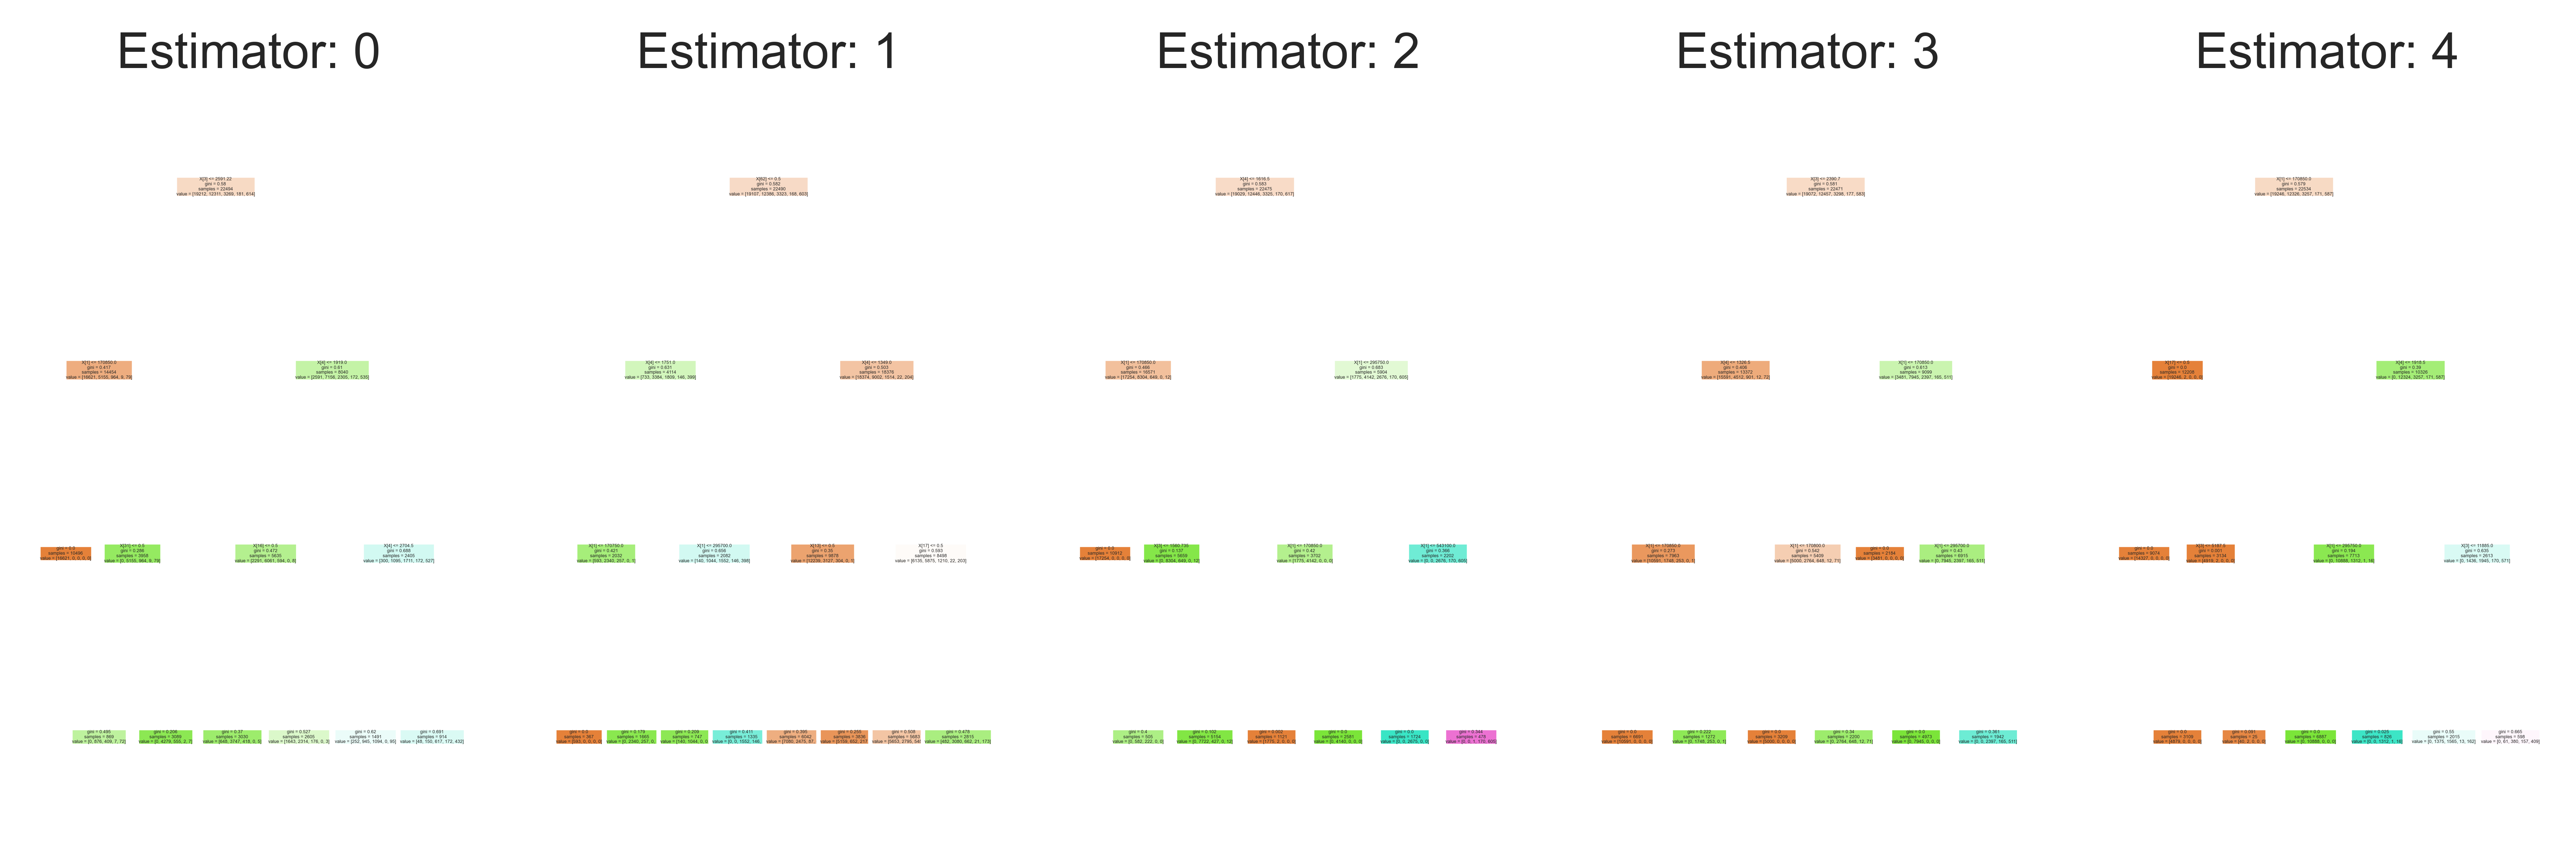

In [178]:
fig, axes = plt.subplots(nrows = 1 ,ncols = 5,figsize = (10,3), dpi=900)
for index in range(0, 5):
    tree.plot_tree(pipeRF_Tuning1[1].estimators_[index],
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')